### Bias/variance trade-off
- There are two general types of errors made by classifiers - bias and variance errors

  #### Bias error
    - it is the overall difference between expected predictions made by the model and true values
    
  #### Variance error
    - it describes how much distances predictions for the given point vary.
    
The desired state is when both errors are as low as possible. The graphics taken from Scott Fortmann-Roe's blog visualizes the issue really well. Imagine that the center of the target is the perfect model. We are iteratively repeating our experiment, recreating model and using it on the same data points.

#### Underfitting and overfitting
- knowing the errors introduced with bias and variance we can proceed to how these relate to training the model. scikit-learn docs provide very good example to help us visualize the underfitting and overfitting issues.

#### how to detect it
To quantify the effects described, we are going to train the model a couple of times for choosing different parameters value. Let's consider that we would like to find a optimal number of trees - we don't want the model to be very simple, but we also don't want to over-complicate it.

#### The plan is as follows, we will:
  - generate complicated binary classification dataset,
  - use Scikit-learn wrapper,
  - train the model for different values of trees (n_estimators) using stratified 10 fold CV,
  - plot train/test errors

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import vstack

# from sklearn.learning_curve import validation_curve
from sklearn.datasets import load_svmlight_files, make_classification
from sklearn.model_selection import StratifiedKFold, validation_curve
from xgboost.sklearn import XGBClassifier

# for reproducible
seed = 124
np.random.seed(seed)

X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=3, n_repeated=2, random_state=seed)

#### Create 10 fold cross-validation

In [54]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

#### Let's see how the number of trees influence the predictions accuracy.

In [55]:
default_params = { 'objective' : 'binary:logistic',
                   'max_depth' : 1,
                   'silent' : 1,
                   'learning_rate' : 0.3}

n_estimator_range = np.linspace(1, 200, 10).astype(int)

train_scores, test_scores = validation_curve( XGBClassifier(**default_params),
                                              X, y, 
                                              param_name = 'n_estimators',
                                              param_range = n_estimator_range,
                                              cv = cv,
                                              scoring = 'accuracy')

#### Show the validation curve plot

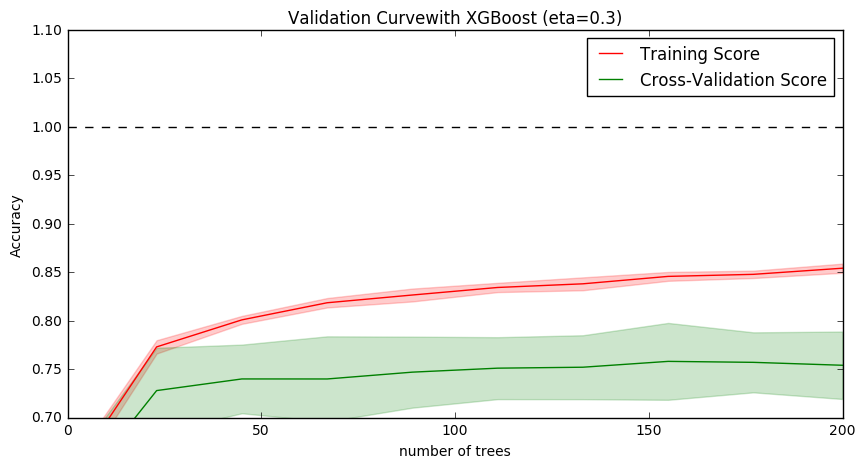

Best Cross-validation results(0.76) obtained for 155 trees


In [57]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10,5), dpi=100)

plt.title("Validation Curvewith XGBoost (eta=0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimator_range, train_scores_mean, label='Training Score', color='r')
plt.plot(n_estimator_range, test_scores_mean, label='Cross-Validation Score', color='g')
plt.fill_between(n_estimator_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.2, color='r')
plt.fill_between(n_estimator_range, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.2, color='g')

plt.axhline(y=1, color='k', ls='dashed')
plt.legend(loc='best')
plt.show()

i = np.argmax(test_scores_mean)
print("Best Cross-validation results({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimator_range[i]))

#### looking at the plot we can draw the following conclusions:
- training score keeps growing while adding new trees, but from a certain point CV score is fixed
- variance is lowest, and bias is high for less than 25 trees, 
- from about 25 trees, the variance is getting higher and while the CV score bias is holding steady (there is no point for adding extra trees / complexity)
- we can see that the model is quite stable keeping variance fixed when increasing it's complexity

We can assume that the trade-off for our model will be met at n_estimators = 50. The variance is still too big

### What we can do?

#### Dealing with high variance

if model is too complex, try:
- using less features (ie. feature selection)
- using more traininig samples (ie. artificially generated)
- increasing regularization (add penalties for extra complexity)

In XGBoost, you can try to:
- reduce depth of each tree (max_depth),
- increase gamma parameter,
- increase min_child_weight parameter
- add more randomness using subsample, colsample_bytree parameters,
- increase lambda and alpha regulariation parameters

#### Dealing with high bias

if model is too simple:
- add more features (ie. better feature engineering)
- more sophistiicated model
- decrease regularization

in XGBoost, you could do it by:
- increase depth of each tree (max_depth)
- decrease min_child-weight parameter
- decrease gamma parameter
- decrease lambda and alpha regularization parameters

Let's try to tweak a parameters a little bit. We are going to add some randomness - each tree we wil use 70% randomly chosen samples and 60% randomly chosen features. This should help to reduce a variance. To decrease the bias (bigger accuracy) try adding an extra level to each tree.

In [58]:
default_params = { 'objective' : 'binary:logistic',
                   'max_depth' : 2, # changed from 1
                   'learning_rate' : 0.3,
                   'silent' : 1,
                   'colsample_bytree' : 0.6,  # newly added
                   'subsample' : 0.7   # newly added
                 }

n_estimator_range = np.linspace(1,200,10).astype(int)

train_scores, test_scores = validation_curve( XGBClassifier(**default_params),
                                              X, y,
                                              param_name = 'n_estimators',
                                              param_range = n_estimator_range,
                                              cv=cv,
                                              scoring='accuracy')

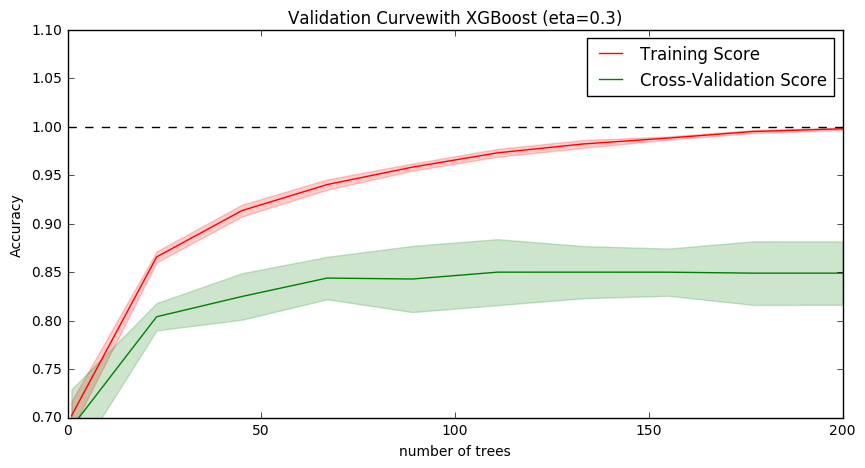

Best Cross-validation results(0.85) obtained for 111 trees


In [59]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10,5), dpi=100)

plt.title("Validation Curvewith XGBoost (eta=0.3)")
plt.xlabel("number of trees")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.1)

plt.plot(n_estimator_range, train_scores_mean, label='Training Score', color='r')
plt.plot(n_estimator_range, test_scores_mean, label='Cross-Validation Score', color='g')
plt.fill_between(n_estimator_range, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std, alpha=0.2, color='r')
plt.fill_between(n_estimator_range, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std, alpha=0.2, color='g')

plt.axhline(y=1, color='k', ls='dashed')
plt.legend(loc='best')
plt.show()

i = np.argmax(test_scores_mean)
print("Best Cross-validation results({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimator_range[i]))

Both of them are improved! The training model reaches ~100%, while testing part is also getting better. But there is still a big gap between training and test dataset!

### How to handle missing data 
  #### in both native XGBoost interface or in Scikit-Learn wrapper
Missing value is commonly seen in real-world data sets. Handling missing values has no rule to apply to all cases, since there could be various reasons for the values to be missing

In [60]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score

seed = 1123
np.random.seed(seed)

# create a dataset with 10 entities (rows), each contains 5 features (columns)
data = np.random.rand(10, 5) 
data

array([[ 0.3144082 ,  0.924563  ,  0.41890814,  0.05678322,  0.63841102],
       [ 0.0937656 ,  0.51524553,  0.64574343,  0.35365654,  0.23803487],
       [ 0.84730508,  0.12077011,  0.91308702,  0.39818432,  0.78950441],
       [ 0.0700342 ,  0.10047113,  0.46255323,  0.93258842,  0.11172449],
       [ 0.05847577,  0.60862662,  0.99733387,  0.69751683,  0.89561129],
       [ 0.82729728,  0.02032949,  0.27279257,  0.9697862 ,  0.90873154],
       [ 0.45043825,  0.57947689,  0.78190538,  0.9997895 ,  0.99153555],
       [ 0.6073961 ,  0.33974511,  0.13860018,  0.9604166 ,  0.08224741],
       [ 0.26674972,  0.58389889,  0.47133722,  0.75557147,  0.11145462],
       [ 0.02635677,  0.76077836,  0.72044929,  0.96828508,  0.61585684]])

In [61]:
# make a copy and add some missing values
data_m = np.copy(data)

data_m[2,3] = np.nan
data_m[1,1] = np.nan
data_m[2,0] = np.nan
data_m[5,4] = np.nan
data_m[7,0] = np.nan
data_m[5,2] = np.nan
data_m[9,3] = np.nan
data_m[2,4] = np.nan
data_m[3,3] = np.nan
data_m[9,1] = np.nan
data_m[6,0] = np.nan

data_m

array([[ 0.3144082 ,  0.924563  ,  0.41890814,  0.05678322,  0.63841102],
       [ 0.0937656 ,         nan,  0.64574343,  0.35365654,  0.23803487],
       [        nan,  0.12077011,  0.91308702,         nan,         nan],
       [ 0.0700342 ,  0.10047113,  0.46255323,         nan,  0.11172449],
       [ 0.05847577,  0.60862662,  0.99733387,  0.69751683,  0.89561129],
       [ 0.82729728,  0.02032949,         nan,  0.9697862 ,         nan],
       [        nan,  0.57947689,  0.78190538,  0.9997895 ,  0.99153555],
       [        nan,  0.33974511,  0.13860018,  0.9604166 ,  0.08224741],
       [ 0.26674972,  0.58389889,  0.47133722,  0.75557147,  0.11145462],
       [ 0.02635677,         nan,  0.72044929,         nan,  0.61585684]])

Generate target variables. Each sample will be assigned to one of two classes - so we are dealing with binary classification problem.

In [62]:
np.random.seed(123)

label = np.random.randint(2, size=10)  # binary target
label

array([0, 1, 0, 0, 0, 0, 0, 1, 1, 0])

### XGBoost native interface
in this case, we will check how does the native interface handles missing data. Begin with specifying default parameters

In [63]:
# general training parameters
params = { 'objective' : 'binary:logistic',
           'max_depth' : 1,
           'silent' : 1,
           'eta' : 0.5}
num_rounds = 5

# first try the perfect dataset
dtrain = xgb.DMatrix(data, label=label)
xgb.cv(params, dtrain, num_rounds, seed=seed)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.222222,0.157135,0.222222,0.078567
1,0.222222,0.157135,0.222222,0.078567
2,0.222222,0.157135,0.222222,0.078567
3,0.222222,0.157135,0.222222,0.078567
4,0.222222,0.157135,0.222222,0.078567


The output obviously doesn't make sense, because the data it completely random!!!

When creating DMatrix holding missing values, we have to explicitly tell what denotes that it's missing. Sometimes it might be 0, 999 or others. In our case, it's Numpy's NAN. Add missing argument to DMatrix constructor to handle it.

In [64]:
dtrain_m = xgb.DMatrix(data_m, label=label, missing=np.nan)

# cross validation
xgb.cv(params, dtrain_m, num_rounds, seed=seed)

,test-error-mean,test-error-std,train-error-mean,train-error-std
0,0.222222,0.157135,0.222222,0.078567
1,0.222222,0.157135,0.222222,0.078567
2,0.222222,0.157135,0.222222,0.078567
3,0.222222,0.157135,0.222222,0.078567
4,0.222222,0.157135,0.222222,0.078567


There is no error! It looks like the algorithm works also with missing values.

In XGBoost, it chooses a soft way to handle missing value. When using a feature whth missing values to do splitting, XGBoost will assign a direction to the missing values instead of a numerical values.
- Specifically, XGBoost guides all the data points with missing values to the left and right respectively, then choose the direction with a higher gain with regard to the objective.

### Using Scikit-learn Wrapper
- the following shows how to validate the same behavior using sklearn wrapper

In [65]:
params = { 'objective' : 'binary:logistic',
           'max_depth' : 1,
           'silent' : 1,
           'learning_rate' : 0.5,
           'n_estimators' : 5}

clf = XGBClassifier(**params)
clf

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=None, n_estimators=5, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=1)

Cross-validate results with full dataset. Because we have only 10 samples, we wil perform 2-fold CV

In [66]:
cross_val_score(clf, data, label, cv=2, scoring='accuracy')

array([ 0.66666667,  0.75      ])

Somoe score was obtained, we won't dig into its interpretation

#### Let's see if things work also with missing values

In [67]:
cross_val_score(clf, data_m, label, cv=2, scoring='accuracy')

array([ 0.66666667,  0.75      ])

Both methods work with missing datasets. The sklearn package by default handles data with np.nan as missing (so you will need additional pre-processing if using different convention)

### Handle Imbalanced Dataset
  #### Imbalanced data refers to a classification problems where the classes (targets) are not equally distributed

There are plenty of examples in real-world problems that deals with imbalanced target classes. 
- Imagine medical data where there are only a few positive instances out of thousands of negative (normal) ones. 
- Another example might be analyzing fraud transaction, in which the actual frauds represent only a fraction of all available data

### General advices
There are some common tactics when approaching imbalanced datasets:
  - collect more data
  - use better evaluation metric (that notices mistakes -ie. AUC, f1, Kappa ...)
  - try oversampling minority class or undersampling majority class
  - generate artificial samples of minority class (ie. SMOTE algorithm)
  
#### in XGBoost, you can try to
  - make sure that parameter min_child_weight is small (because leaf nodes can have smaller size groups). It is set to min_child_weight=1 by default
  - assign more weights to specific samples while initializing DMatrix
  - control the balance of positive and negative weights using set_pos_weight parameter
  - use AUC for evaluation

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# for reproduciblility
seed = 133

X, y = make_classification(n_samples=200, n_features=5, n_informative=3, n_classes=2, 
                           weights=[.9, .1], shuffle=True, random_state=seed)

print("There are {} positive instances.".format(y.sum()))

There are 21 positive instances.


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=seed)

print("Total number of positive train instances: {}".format(y_train.sum()))
print("Total number of positive test instances: {}".format(y_test.sum()))

Total number of positive train instances: 14
Total number of positive test instances: 7


#### Baseline model
- In this approach try to completely ignore the fact that classes are imbalanced and see how it will perform. Create DMatrix for train and test data
- Assume that we will create 15 decision tree stamps, solving binary classification problem, where each next one will be trained very aggressively.
- These parameters will also be used in the consecutive examples

In [70]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

params = { 'objective' : 'binary:logistic',
           'max_depth' : 1,
           'silent' : 1,
           'eta' : 1}

num_rounds = 15
clf = xgb.train(params, dtrain, num_rounds)
y_test_pred = clf.predict(dtest)
y_test_pred = (y_test_pred > 0.5).astype('int')
print("The predicted values are:", y_test_pred)

The predicted values are: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [71]:
import pandas as pd

pd.crosstab( pd.Series(y_test, name='Actual'), 
             pd.Series(y_test_pred, name='Predicted'),
             margins=True)

Predicted,0,1,All
Actual,,,
0,59,0,59
1,2,5,7
All,61,5,66


We can also present the performance using 3 different evaluation metrics:
- accuracy
- precision (the ability of the classifier not to label as positive a sample that is negative)
- recall (the ability of the classifier to find all the positive samples)

In [72]:
print("Accuracy: {0:.2}".format(accuracy_score(y_test, y_test_pred)))
print("Precisio: {0:.2f}".format(precision_score(y_test, y_test_pred)))
print("Recalll: {0:.2f}".format(recall_score(y_test, y_test_pred)))

Accuracy: 0.97
Precisio: 1.00
Recalll: 0.71


Intuitively we know that the focus should be on finding positive samples. First results are very promising (94% accuracy - wow), but deeper analysis show that the results are biased towards majority class - we are very poor at predicting the actual label of positive instances. That is called an accuracy paradox.

#### Custom Weights
- Try to explicitly tell the algorithm what important using relative instance weights. Let's specify that positive instances have 5x more weight and add this information while creating DMatrix

In [73]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 5

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)
dtest  = xgb.DMatrix(X_test)

bst = xgb.train(params, dtrain, num_rounds)
y_pred = (bst.predict(dtest) > 0.5).astype('int')

pd.crosstab( pd.Series(y_test, name='Actual'),
             pd.Series(y_pred, name='Predicted'),
             margins=True)

Predicted,0,1,All
Actual,,,
0,56,3,59
1,1,6,7
All,57,9,66


In [74]:
print("Accuracy: {0:.2}".format(accuracy_score(y_test, y_pred)))
print("Precisio: {0:.2f}".format(precision_score(y_test, y_pred)))
print("Recalll: {0:.2f}".format(recall_score(y_test, y_pred)))

Accuracy: 0.94
Precisio: 0.67
Recalll: 0.86


We see that we made a trade-off here. We are row able to better classify the minority class, but the overall accuracy and preciion decreased. Test multiple weights combinations and see which one works best.

#### Use scale_pos_weight parameter
you can automate the process of asssigning weights manually by ccalculating the proportion between negative and positive instances and setting it to scale_pos_weight parameter

In [75]:
# re-initialize the datasets
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test)

# calculate the ratio between both classes and assign it to a parameter
train_labels = dtrain.get_label()

ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
params['scale_pos_weights'] = ratio

# and like before, analyze the confusion matrix and obtained metrics
bst = xgb.train(params, dtrain, num_rounds)
y_pred = (bst.predict(dtest) > 0.5).astype('int')

pd.crosstab( pd.Series(y_test, name="Actual"),
             pd.Series(y_pred, name='Predicted'),
             margins = True)

Predicted,0,1,All
Actual,,,
0,59,0,59
1,2,5,7
All,61,5,66


In [76]:
print("Accuracy: {0:.2}".format(accuracy_score(y_test, y_pred)))
print("Precisio: {0:.2f}".format(precision_score(y_test, y_pred)))
print("Recalll: {0:.2f}".format(recall_score(y_test, y_pred)))

Accuracy: 0.97
Precisio: 1.00
Recalll: 0.71


We can see that scaling weight by using scale_pot_weights in this case gives better results that doing it manually. We are not able to perffectly classify all positive classes (focusing on the real problem). On the other hand, the classifier sometimes makes a mistake by wrongly classifying the negative case into positive (producing so called false positives).